# Nghĩ ...

- Xác định các môn có dây LT và BT để tạo thành các cụm
- Có danh sách các cụm đi cùng với nhau:
- Chọn cụm đầu tiên, không xét các dòng cùng tên khác cụm này, lần lượt chọn cụm tiếp theo, xoá và làm tiếp... Trong đó cần xét các ca có trùng nhau hay không

Coi thứ, ca chính là toạ độ điểm trong TKB, nơi nào đánh dấu rồi là không thể điền. VD: thứ 2 ca 6-8 là các điểm: (2,6),(2,7),(2,8). Vì vậy coi mỗi cụm môn là 1 danh sách chứa các điểm toạ độ. Các cụm khác nhau không được có chung 1 điểm nào.
Lưu ý trường hợp:
- Lớp theo dây: Giải tích 2: GIAITICH2.1_LT sẽ có 2 lớp: GIAITICH2.1.1_BT, GIAITICH2.1.2_BT
    + Cần bỏ đuôi _LT sau đó tìm số tương ứng bù vào, tuỳ vào số lớp mà thêm các trường hợp.

# Thư viện và hàm

In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

## Các hàm

In [11]:
def search_name(text):
    """
    Tìm danh sách các môn học chứa đoạn văn bản người nhập
        - text: Văn bản người nhập
    return: Danh sách các môn học có chứa text
    """
    txt = text.lower()
    return [subj for subj in uni_subjects if txt in subj.lower()]
def get_data_LT(class_name, df_subj):
    """
    Tìm ra danh sách các lớp cùng 1 môn đi chung với nhau nhưng khác ngày hoặc khác ca.
    Bao gồm cả trường hợp 1 lớp LT nhưng nhiều lớp BT và có thể lớp BT cũng có nhiều buổi khác nhau.
        - class_name: (str) tên lớp
        - df_subj: (DataFrame) Các lớp cùng tên môn, df_subj này sẽ thay đổi đến khi rỗng
    return:
        - Nếu rỗng: -1. Để cho hàm xử lý
        - Còn lại: Trả về 1 danh sách các lớp cùng 1 môn đi chung với nhau.
    """
    # TH lớp _LT là cuối cùng, không còn lớp _BT nào nữa
    if len(df_subj.index[1:]) == 0: # 
        return -1
    
    lst_data = []
    class_name_new = class_name.replace("_LT",'')
    
    # Tìm ra unique các lớp bài tập. Vì có thể có trường hợp 2 lớp BT ở 2 buổi
    lst_BT = []
    for idx in df_subj.index[1:]:
        cname = df_subj.at[idx,"Tên lớp"]
        if class_name_new in cname:
            if cname not in lst_BT:
                lst_BT.append(cname)
                
    # Tìm ra các cặp lớp LT - BT tương ứng
    for nameBT in lst_BT:
        df_tmp = df_subj[df_subj['Tên lớp'] == nameBT]        
        lst_idx = [df_subj.index[0]] + list(df_tmp.index)
            
        lst_data.append(df_subj.loc[lst_idx])
        # Giữ lại phần tử đầu tiên (lớp LT) để cho lần lặp tiếp theo
        df_subj.drop(lst_idx[1:], inplace = True)
        
    # Sau khi thêm hết các cặp, xoá nốt phần tử đầu tiên (lớp LT)
    df_subj.drop(df_subj.index[0], inplace = True)
    
    return lst_data

def get_df_sort_class(df_subj):
    """
    Sắp xếp lại dataFrame các môn cùng tên, các môn này là các môn có LT và BT
    Các lớp LT được xếp lên đầu, sau đó là các lớp BT.
    Mục đích là để tận dụng code, không phân trường hợp LT hay BT
        - df_subj: dataFrame các môn học có cùng tên, được chia làm tiết LT và BT
    return: dataframe đã được sắp xếp
    """
    lst_index_LT = df_subj.index[df_subj["Tên lớp"].str.contains("_LT")].tolist()
    lst_index_BT = df_subj.index[df_subj["Tên lớp"].str.contains("_BT")].tolist()

    new_index = lst_index_LT + lst_index_BT
    # Nếu không tìm thấy lớp LT hoặc BT, trả về chính df_subj ban đầu
    if not new_index:
        return df_subj
    return df_subj.loc[new_index].reset_index(drop=True)

def get_all_subj_class(class_name, df_subj, isLTBT = False):
    """
    Tìm ra DataFrame là các lớp cùng 1 môn đi kèm với nhau nhưng khác ngày hoặc khác ca.
        - class_name: (str) Tên lớp học
        - df_subj: (DataFrame) Các lớp cùng tên môn, df_subj này sẽ thay đổi đến khi rỗng
        - isLTBT: (bool) Môn học có giờ LT và BT hay không. default = False
    return danh sách (DataFrame) các lớp đi chung với nhau.
    VD: Python.1 thứ 2 ca 3-5 và Python.1 thứ 3 ca 1-2
    """
    # Trong trường hợp chỉ có 1 tiết duy nhất hoặc df rỗng
    if len(df_subj) == 1:
        return df_subj
    # Nếu môn này là môn có LT, BT
    if isLTBT:
        return get_data_LT(class_name, df_subj) 
    else:
        # Chọn lớp đầu tiên của df
        lst_index = [df_subj.index[0]]
        for idx in df_subj.index[1:]:
            if df_subj.at[idx,"Tên lớp"] == class_name:
                lst_index.append(idx)
        rs_df = df_subj.loc[lst_index]
        # Sau khi có df của các lớp đi chung với nhau, loại bỏ khỏi df môn học ban đầu
        df_subj.drop(lst_index, inplace = True)
        return rs_df
def get_df_None(day = 7, shift = 13):
    """
    Tạo thời khoá biểu rỗng, cột là day, dòng là shift
        - day: Số ngày trong tuần (bắt đầu từ 1: Chủ nhật)
        - shift: Số ca trong 1 ngày
    return dataFrame thời khoá biểu rỗng
    """
    return pd.DataFrame(np.nan, index=range(1, shift+1), columns=range(1, day+1))

def generate(dset, df_, current_C=[], result=[]):
    """
    DFS để tìm thới khoá biểu. 
    return Danh sách các môn học, thời khoá biểu có thể đăng ký
    """
    if not dset:
        result.append((current_C, df_.fillna(" ")))
        return result
    current_set = dset[0]
    for item in current_set.keys():
        dftkb = df_.copy()
        can_fill = True
        df_class = current_set[item]
        for index in df_class.index:
            start_shift, end_shift = np.array(df_class.at[index,'Ca'].split('-')).astype(int)
            day_of_week = int(df_class.at[index,"Thứ"])
            for shift in range(start_shift, end_shift + 1):
                if not pd.isnull(dftkb.at[shift, day_of_week]):
                    can_fill = False
                    break
            if not can_fill:
                break
        if can_fill:
            df_class = current_set[item]
            for index in df_class.index:
                class_name = df_class.at[index,'Tên lớp']
                start_shift, end_shift = np.array(df_class.at[index,'Ca'].split('-')).astype(int)
                day_of_week = int(df_class.at[index,"Thứ"])
                for shift in range(start_shift, end_shift + 1):
                    dftkb.at[shift, day_of_week] = str(class_name)
            result = generate(dset[1:], dftkb, current_C + [item], result)
    return result

# Nhét vào 1 hàm

In [15]:
def get_list_TKB(df, lst_subj_register):
    df_register = df[df['Tên môn'].isin(lst_subj_register)].reset_index(drop=True)

    dict_node = {}
    for subj_name in lst_subj_register:
        lst_node = []
        # DataFrame các lớp cùng môn
        df_subj = df_register[df_register['Tên môn'] == subj_name].reset_index(drop=True)

        # Kiểm tra có phải môn có cặp LT-BT hay không
        first_index = df_subj.index[0]
        isLTBT = False
        if "_LT" in df_subj.at[first_index, "Tên lớp"] or "_BT" in df_subj.at[first_index, "Tên lớp"]:
            isLTBT = True
            # Nếu là LT-BT thì sắp xếp cho tất cả LT lên đầu, BT ở sau
            # Mục đích là để tận dụng code, không phân trường hợp LT hay BT
            df_subj = get_df_sort_class(df_subj)

        while not df_subj.empty:
            first_index = df_subj.index[0]
            class_name = df_subj.at[first_index, "Tên lớp"]
            data = get_all_subj_class(class_name, df_subj, isLTBT)
            if type(data) == int:
                break
            if type(data) == list:
                for dt in data:
                    lst_node.append(dt)
            else:
                lst_node.append(data)
        dict_node[subj_name] = lst_node

    lst_gc = []
    for key in dict_node.keys():
        name_sub_class = {}
        for i in range(len(dict_node[key])):
            name_sub_class['-'.join(np.unique(dict_node[key][i]['Tên lớp']))] = dict_node[key][i]
        lst_gc.append(name_sub_class)
    return generate(lst_gc, get_df_None(), [], [])

In [170]:
df[df["Tên môn"] == "Học máy"]

,STT,Mã môn,Tên môn,Tên lớp,Thứ,Ca,Phòng học,TC,Giáo viên
288,289,CS320,Học máy,HOCMAY.1,2,1-3,A705,3,Đoàn Trung Phong(PAI007)
289,290,CS320,Học máy,HOCMAY.2,2,9-11,A707,3,Đoàn Trung Phong(PAI007)
290,291,CS320,Học máy,HOCMAY.2,4,1-3,A705,3,Đoàn Trung Phong(PAI007)
291,292,CS320,Học máy,HOCMAY.1,4,6-8,A705,3,Đoàn Trung Phong(PAI007)


In [169]:
df = pd.read_csv("D:\\Documents\\dangkyhoc.csv", header=1)
uni_subjects = np.unique(df["Tên môn"])
lst_subj_register = [search_name("Tiếng Anh trung cấp 1")[0],
                    search_name("Khai phá")[0],
                    search_name("Giải tích 2")[0],
                    search_name("(MC)")[0],
                    search_name("kiến trúc máy")[0],
                    search_name("kế hướng đối tượng")[0]]
rs = get_list_TKB(df.copy(),lst_subj_register.copy())
num_rs = len(rs)

for i in range(num_rs):
    for j in range(i+1,num_rs):
        if rs[i][1].equals(rs[j][1]):
            print("Trùng: ",i,j)
filter_rs = []
mask = ["KTRUCMAYTINH.3","TKEHDOITUONG.2","GIAITICH2.2.1_BT","KHAIPHADULIEU.3","DANCT(MC).8","TANHTC1.11"]
must = len(mask)
for tkb in rs:
    cnt = 0
    for m in mask:
        for v in tkb[0]:
            if m in v:
                cnt += 1
                break
    if cnt == must:
        filter_rs.append(tkb)
print(f"Số TKB có thể: {num_rs}\nSố TKB sau khi lọc {len(filter_rs)}")

Số TKB có thể: 329
Số TKB sau khi lọc 1


In [167]:
filter_rs[0][1]

,1,2,3,4,5,6,7
1,,,,,,TANHTC1.11,TANHTC1.11
2,,,,,,TANHTC1.11,TANHTC1.11
3,,,,,,TANHTC1.11,TANHTC1.11
4,,TKEHDOITUONG.2,,,,KTRUCMAYTINH.3,
5,,TKEHDOITUONG.2,,,,KTRUCMAYTINH.3,
6,DANCT(MC).8.1_BT,,DANCT(MC).8_LT,,,KTRUCMAYTINH.3,KHAIPHADULIEU.3
7,DANCT(MC).8.1_BT,,DANCT(MC).8_LT,,,KTRUCMAYTINH.3,KHAIPHADULIEU.3
8,DANCT(MC).8.1_BT,TKEHDOITUONG.2,DANCT(MC).8_LT,GIAITICH2.2_LT,,KTRUCMAYTINH.3,KHAIPHADULIEU.3
9,,TKEHDOITUONG.2,GIAITICH2.2.1_BT,GIAITICH2.2_LT,KHAIPHADULIEU.3,,GIAITICH2.2.1_BT
10,,TKEHDOITUONG.2,GIAITICH2.2.1_BT,GIAITICH2.2_LT,KHAIPHADULIEU.3,,GIAITICH2.2.1_BT


In [161]:
filter_rs[0][1]

,1,2,3,4,5,6,7
1,,,,,,TANHTC1.11,TANHTC1.11
2,,,,,,TANHTC1.11,TANHTC1.11
3,,,,,,TANHTC1.11,TANHTC1.11
4,,TKEHDOITUONG.2,,,,KTRUCMAYTINH.3,
5,,TKEHDOITUONG.2,,,,KTRUCMAYTINH.3,
6,DANCT(MC).8.1_BT,,DANCT(MC).8_LT,,,KTRUCMAYTINH.3,KHAIPHADULIEU.3
7,DANCT(MC).8.1_BT,,DANCT(MC).8_LT,,,KTRUCMAYTINH.3,KHAIPHADULIEU.3
8,DANCT(MC).8.1_BT,TKEHDOITUONG.2,DANCT(MC).8_LT,GIAITICH2.2_LT,,KTRUCMAYTINH.3,KHAIPHADULIEU.3
9,,TKEHDOITUONG.2,GIAITICH2.2.1_BT,GIAITICH2.2_LT,KHAIPHADULIEU.3,,GIAITICH2.2.1_BT
10,,TKEHDOITUONG.2,GIAITICH2.2.1_BT,GIAITICH2.2_LT,KHAIPHADULIEU.3,,GIAITICH2.2.1_BT


# Đọc dữ liệu

In [9]:
options = Options()
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")
options.add_argument("--blink-settings=imagesEnabled=false")
options.add_argument("--window-size=400,400")
# options.add_argument("--headless")

In [23]:
driver = webdriver.Chrome(ChromeDriverManager().install())

In [24]:
def login_TLU(username, password):
    url_login = "https://login.thanglong.edu.vn/?partner=DKH&data=8h%2b6%2bk%2fTeZ66vm6RFQ2n1T5UOIEWWEB3WVsNrJdW8qN%2f1O2BfB6cHxbeBB7ai45JG4xC5unFPNxPtAMWOuSWltbNzjvRF%2fF5RhJfFMii2Pt%2bI18rdu605L6mAXdUrFQUg98dD3b%2b3eYmmtvz4CEhymkzfewIr9bi%2f9sVU4rQy9w%3d"
    driver.get(url_login)
    driver.implicitly_wait(2)
    element_user = driver.find_element(By.NAME, "tbUserName")
    element_pass = driver.find_element(By.NAME, "tbPassword")
    element_user.send_keys(username)
    element_pass.send_keys(password)
    driver.find_element(By.NAME, "btLogin").click()
    driver.implicitly_wait(2)
#     if driver.current_url not in "https://dangkyhoc.thanglong.edu.vn/Default.aspx":
#         return False
#     return True

In [25]:
login_TLU("A42048","1Aandthrk3072002")
# if success:
#     driver.get("https://dangkyhoc.thanglong.edu.vn/ToanTruong/TKBToanTruong.aspx")

In [100]:
element_select_year = Select(driver.find_element(By.ID, "ctl00_c_droNam"))

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="ctl00_c_droNam"]"}
  (Session info: chrome=119.0.6045.160)


In [ ]:
element_select_year.options

In [ ]:
dic_year = {}  
for i, elm in enumerate(element_select_year.options):
    print(i, elm.text)
    element_select_year.select_by_index(i)
    driver.implicitly_wait(2)
    elm_hk = Select(driver.find_element(By.ID, "ctl00_c_droHocki"))
    dic_year[elm] = elm_hk
    driver.implicitly_wait(2)

In [57]:
df = pd.read_csv("D:\\Documents\\dangkyhoc.csv", header=1)
df.head()

,STT,Mã môn,Tên môn,Tên lớp,Thứ,Ca,Phòng học,TC,Giáo viên
0,1,SK460,Thực tập ngành công tác xã hội,TTTOTNGHIEPCTXH.1,1,1-5,BOMON1,4,Nguyễn Thị Bùi Thành(CXW004)
1,2,AD206,Ẩm thực Việt Nam,AMTHUCVN.2.1_BT,3,1-3,BOMON1,3,NaN
2,3,AD206,Ẩm thực Việt Nam,AMTHUCVN.2.2_BT,3,6-8,BOMON1,3,NaN
3,4,AD206,Ẩm thực Việt Nam,AMTHUCVN.2_LT,5,3-5,B303,3,Nguyễn Nhiên Hương(MDL026)
4,5,TC316,An ninh mạng truyền thông,ANNINHTRUYENTHONG.1,3,1-2,A603,3,Hoàng Trọng Minh(CTI030)


In [59]:
lst_subj_register = [search_name("Tiếng Anh trung cấp 1")[0],
                    search_name("Khai phá")[0],
                    search_name("Giải tích 2")[0],
                    search_name("Thuật toán")[0],
                    search_name("(MC)")[0],
                    search_name("Kiến trúc")[0],
                    search_name("hệ thống thông tin")[0]
                    ]
lst_subj_register

['Tiếng Anh trung cấp 1',
 'Khai phá dữ liệu',
 'Giải tích 2',
 'Phân tích và thiết kế thuật toán',
 'Dẫn chương trình (MC)',
 'Kiến trúc máy tính',
 'Hệ thống thông tin']

In [60]:
df_register = df[df['Tên môn'].isin(lst_subj_register)].reset_index(drop=True)
df_register

,STT,Mã môn,Tên môn,Tên lớp,Thứ,Ca,Phòng học,TC,Giáo viên
0,133,AD241,Dẫn chương trình (MC),DANCT(MC).9.1_BT,1,6-8,BOMON,3,Trần Thị Thùy Dương(CXC006)
1,134,AD241,Dẫn chương trình (MC),DANCT(MC).4.1_BT,1,6-8,BOMON,3,Nguyễn Văn Thiệu(CXC004)
2,135,AD241,Dẫn chương trình (MC),DANCT(MC).5.1_BT,1,6-8,BOMON,3,Vũ Thị Thanh Nhàn(CXC001)
3,136,AD241,Dẫn chương trình (MC),DANCT(MC).6.1_BT,1,6-8,BOMON,3,Vũ Thị Thanh Nhàn(CXC001)
4,137,AD241,Dẫn chương trình (MC),DANCT(MC).7.1_BT,1,6-8,BOMON,3,Nguyễn Văn Thiệu(CXC004)
...,...,...,...,...,...,...,...,...,...
121,1147,GE231,Tiếng Anh trung cấp 1,TANHTC1.30,7,8-10,B410,2,NaN
122,1148,GE231,Tiếng Anh trung cấp 1,TANHTC1.28,7,9-10,B404,2,NaN
123,1149,GE231,Tiếng Anh trung cấp 1,TANHTC1.36,7,9-10,B502,2,NaN
124,1150,GE231,Tiếng Anh trung cấp 1,TANHTC1.19,7,9-10,A505,2,NaN


# Tạo thời khoá biểu
## Phân thành dictionary
- Key: Tên môn học
- Value: Danh sách các DataFrame, mỗi DataFrame là các môn học luôn đi cùng với nhau
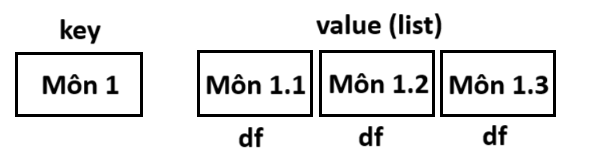

In [61]:
dict_node = {}
for subj_name in lst_subj_register:
    lst_node = []
    # DataFrame các lớp cùng môn
    df_subj = df_register[df_register['Tên môn'] == subj_name].reset_index(drop=True)
    
    # Kiểm tra có phải môn có cặp LT-BT hay không
    first_index = df_subj.index[0]
    isLTBT = False
    if "_LT" in df_subj.at[first_index, "Tên lớp"] or "_BT" in df_subj.at[first_index, "Tên lớp"]:
        isLTBT = True
        # Nếu là LT-BT thì sắp xếp cho tất cả LT lên đầu, BT ở sau
        # Mục đích là để tận dụng code, không phân trường hợp LT hay BT
        df_subj = get_df_sort_class(df_subj)

    while not df_subj.empty:
        first_index = df_subj.index[0]
        class_name = df_subj.at[first_index, "Tên lớp"]
        data = get_all_subj_class(class_name, df_subj, isLTBT)
        if type(data) == int:
            break
        if type(data) == list:
            for dt in data:
                lst_node.append(dt)
        else:
            lst_node.append(data)
    dict_node[subj_name] = lst_node

## Chuyển thành danh sách các node để ghép với nhau
Lúc này các node là 1 dataframe các lớp luôn đi cùng nhau (trong web trường là 1 ô tích để đăng ký :>)

Yên tâm là có kiểm tra để không cho 2 môn cùng 1 trong TKB trong hàm generate :>

In [62]:
lst_gc = []
for key in dict_node.keys():
    name_sub_class = {}
    for i in range(len(dict_node[key])):
        name_sub_class['-'.join(np.unique(dict_node[key][i]['Tên lớp']))] = dict_node[key][i]
    lst_gc.append(name_sub_class)

In [63]:
lst_gc[0].keys()

dict_keys(['TANHTC1.7', 'TANHTC1.20', 'TANHTC1.33', 'TANHTC1.35', 'TANHTC1.8', 'TANHTC1.22', 'TANHTC1.9', 'TANHTC1.23', 'TANHTC1.34', 'TANHTC1.32', 'TANHTC1.24', 'TANHTC1.10', 'TANHTC1.12', 'TANHTC1.16', 'TANHTC1.25', 'TANHTC1.26', 'TANHTC1.17', 'TANHTC1.13', 'TANHTC1.14', 'TANHTC1.18', 'TANHTC1.27', 'TANHTC1.31', 'TANHTC1.19', 'TANHTC1.15', 'TANHTC1.28', 'TANHTC1.36', 'TANHTC1.29', 'TANHTC1.21', 'TANHTC1.11', 'TANHTC1.30'])

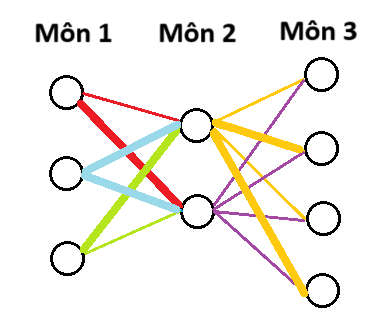

- Các đường tô đậm là có thể ghép với nhau
- Các TKB hợp lệ là khi có đường đi từ Môn 1 đến Môn 3.

Việc tối ưu để sau =)) Sắp xếp môn nào trước sau cũng ảnh hưởng tới tốc độ. Không liên quan đến việc ưu tiên môn nào trước sau vì dù gì cũng ra tất cả đáp án. Chỉ cần quan tâm môn nào xếp trước để ra kết quả nhanh nhất.


## Kết quả

In [70]:
lst_copy = lst_gc.copy()
dfNan = get_df_None()
rs = generate(lst_gc, dfNan.copy())
num_rs = len(rs)
print(num_rs)
for i in range(num_rs):
    for j in range(i+1,num_rs):
        if rs[i][1].equals(rs[j][1]):
            print("Trùng: ",i,j)
            

355
Trùng:  0 71
Trùng:  0 142
Trùng:  0 213
Trùng:  0 284
Trùng:  1 72
Trùng:  1 143
Trùng:  1 214
Trùng:  1 285
Trùng:  2 73
Trùng:  2 144
Trùng:  2 215
Trùng:  2 286
Trùng:  3 74
Trùng:  3 145
Trùng:  3 216
Trùng:  3 287
Trùng:  4 75
Trùng:  4 146
Trùng:  4 217
Trùng:  4 288
Trùng:  5 76
Trùng:  5 147
Trùng:  5 218
Trùng:  5 289
Trùng:  6 77
Trùng:  6 148
Trùng:  6 219
Trùng:  6 290
Trùng:  7 78
Trùng:  7 149
Trùng:  7 220
Trùng:  7 291
Trùng:  8 79
Trùng:  8 150
Trùng:  8 221
Trùng:  8 292
Trùng:  9 80
Trùng:  9 151
Trùng:  9 222
Trùng:  9 293
Trùng:  10 81
Trùng:  10 152
Trùng:  10 223
Trùng:  10 294
Trùng:  11 82
Trùng:  11 153
Trùng:  11 224
Trùng:  11 295
Trùng:  12 83
Trùng:  12 154
Trùng:  12 225
Trùng:  12 296
Trùng:  13 84
Trùng:  13 155
Trùng:  13 226
Trùng:  13 297
Trùng:  14 85
Trùng:  14 156
Trùng:  14 227
Trùng:  14 298
Trùng:  15 86
Trùng:  15 157
Trùng:  15 228
Trùng:  15 299
Trùng:  16 87
Trùng:  16 158
Trùng:  16 229
Trùng:  16 300
Trùng:  17 88
Trùng:  17 159
Trùn

Trùng:  185 256
Trùng:  185 327
Trùng:  186 257
Trùng:  186 328
Trùng:  187 258
Trùng:  187 329
Trùng:  188 259
Trùng:  188 330
Trùng:  189 260
Trùng:  189 331
Trùng:  190 261
Trùng:  190 332
Trùng:  191 262
Trùng:  191 333
Trùng:  192 263
Trùng:  192 334
Trùng:  193 264
Trùng:  193 335
Trùng:  194 265
Trùng:  194 336
Trùng:  195 266
Trùng:  195 337
Trùng:  196 267
Trùng:  196 338
Trùng:  197 268
Trùng:  197 339
Trùng:  198 269
Trùng:  198 340
Trùng:  199 270
Trùng:  199 341
Trùng:  200 271
Trùng:  200 342
Trùng:  201 272
Trùng:  201 343
Trùng:  202 273
Trùng:  202 344
Trùng:  203 274
Trùng:  203 345
Trùng:  204 275
Trùng:  204 346
Trùng:  205 276
Trùng:  205 347
Trùng:  206 277
Trùng:  206 348
Trùng:  207 278
Trùng:  207 349
Trùng:  208 279
Trùng:  208 350
Trùng:  209 280
Trùng:  209 351
Trùng:  210 281
Trùng:  210 352
Trùng:  211 282
Trùng:  211 353
Trùng:  212 283
Trùng:  212 354
Trùng:  213 284
Trùng:  214 285
Trùng:  215 286
Trùng:  216 287
Trùng:  217 288
Trùng:  218 289
Trùng:  

In [54]:
filter_rs = []
mask = ["KHAIPHADULIEU.1","(MC).5","KTRUCMAYTINH.1"]
must = len(mask)
for tkb in rs:
    cnt = 0
    for m in mask:
        for v in tkb[0]:
            if m in v:
                cnt += 1
                break
    if cnt == must:
        filter_rs.append(tkb)

In [55]:
rs = generate(lst_gc, get_df_None())
num_rs = len(rs)
print(num_rs)
for i in range(num_rs):
    for j in range(i+1,num_rs):
        if rs[i][1].equals(rs[j][1]):
            print("Trùng: ",i,j)

filter_rs = []
mask = ["KHAIPHADULIEU.1","(MC).5","KTRUCMAYTINH.3"]
must = len(mask)
for tkb in rs:
    cnt = 0
    for m in mask:
        for v in tkb[0]:
            if m in v:
                cnt += 1
                break
    if cnt == must:
        filter_rs.append(tkb)

213
Trùng:  0 71
Trùng:  0 142
Trùng:  1 72
Trùng:  1 143
Trùng:  2 73
Trùng:  2 144
Trùng:  3 74
Trùng:  3 145
Trùng:  4 75
Trùng:  4 146
Trùng:  5 76
Trùng:  5 147
Trùng:  6 77
Trùng:  6 148
Trùng:  7 78
Trùng:  7 149
Trùng:  8 79
Trùng:  8 150
Trùng:  9 80
Trùng:  9 151
Trùng:  10 81
Trùng:  10 152
Trùng:  11 82
Trùng:  11 153
Trùng:  12 83
Trùng:  12 154
Trùng:  13 84
Trùng:  13 155
Trùng:  14 85
Trùng:  14 156
Trùng:  15 86
Trùng:  15 157
Trùng:  16 87
Trùng:  16 158
Trùng:  17 88
Trùng:  17 159
Trùng:  18 89
Trùng:  18 160
Trùng:  19 90
Trùng:  19 161
Trùng:  20 91
Trùng:  20 162
Trùng:  21 92
Trùng:  21 163
Trùng:  22 93
Trùng:  22 164
Trùng:  23 94
Trùng:  23 165
Trùng:  24 95
Trùng:  24 166
Trùng:  25 96
Trùng:  25 167
Trùng:  26 97
Trùng:  26 168
Trùng:  27 98
Trùng:  27 169
Trùng:  28 99
Trùng:  28 170
Trùng:  29 100
Trùng:  29 171
Trùng:  30 101
Trùng:  30 172
Trùng:  31 102
Trùng:  31 173
Trùng:  32 103
Trùng:  32 174
Trùng:  33 104
Trùng:  33 175
Trùng:  34 105
Trùng:  34

In [52]:
for x in filter_rs:
    print(x[0])

['TANHTC1.32', 'KHAIPHADULIEU.1', 'GIAITICH2.1.1_BT-GIAITICH2.1_LT', 'PTTKTHUATTOAN.1.1_BT-PTTKTHUATTOAN.1_LT', 'DANCT(MC).5.1_BT-DANCT(MC).5_LT', 'KTRUCMAYTINH.3', 'HETHONGTTIN.3']
['TANHTC1.32', 'KHAIPHADULIEU.1', 'GIAITICH2.1.2_BT-GIAITICH2.1_LT', 'PTTKTHUATTOAN.1.1_BT-PTTKTHUATTOAN.1_LT', 'DANCT(MC).5.1_BT-DANCT(MC).5_LT', 'KTRUCMAYTINH.3', 'HETHONGTTIN.3']
['TANHTC1.24', 'KHAIPHADULIEU.1', 'GIAITICH2.1.1_BT-GIAITICH2.1_LT', 'PTTKTHUATTOAN.1.1_BT-PTTKTHUATTOAN.1_LT', 'DANCT(MC).5.1_BT-DANCT(MC).5_LT', 'KTRUCMAYTINH.3', 'HETHONGTTIN.3']
['TANHTC1.24', 'KHAIPHADULIEU.1', 'GIAITICH2.1.2_BT-GIAITICH2.1_LT', 'PTTKTHUATTOAN.1.1_BT-PTTKTHUATTOAN.1_LT', 'DANCT(MC).5.1_BT-DANCT(MC).5_LT', 'KTRUCMAYTINH.3', 'HETHONGTTIN.3']
['TANHTC1.10', 'KHAIPHADULIEU.1', 'GIAITICH2.1.1_BT-GIAITICH2.1_LT', 'PTTKTHUATTOAN.1.1_BT-PTTKTHUATTOAN.1_LT', 'DANCT(MC).5.1_BT-DANCT(MC).5_LT', 'KTRUCMAYTINH.3', 'HETHONGTTIN.3']
['TANHTC1.10', 'KHAIPHADULIEU.1', 'GIAITICH2.1.2_BT-GIAITICH2.1_LT', 'PTTKTHUATTOAN.1.1_BT

In [48]:
filter_rs[1][1]

,1,2,3,4,5,6,7
1,,,GIAITICH2.1_LT,GIAITICH2.1.2_BT,,,GIAITICH2.1.2_BT
2,,,GIAITICH2.1_LT,GIAITICH2.1.2_BT,,,GIAITICH2.1.2_BT
3,,,GIAITICH2.1_LT,HETHONGTTIN.3,,,
4,,,,HETHONGTTIN.3,,KTRUCMAYTINH.3,PTTKTHUATTOAN.1_LT
5,,,,HETHONGTTIN.3,,KTRUCMAYTINH.3,PTTKTHUATTOAN.1_LT
6,DANCT(MC).5.1_BT,DANCT(MC).5_LT,KHAIPHADULIEU.1,HETHONGTTIN.3,,KTRUCMAYTINH.3,PTTKTHUATTOAN.1.1_BT
7,DANCT(MC).5.1_BT,DANCT(MC).5_LT,KHAIPHADULIEU.1,HETHONGTTIN.3,,KTRUCMAYTINH.3,PTTKTHUATTOAN.1.1_BT
8,DANCT(MC).5.1_BT,DANCT(MC).5_LT,KHAIPHADULIEU.1,,,KTRUCMAYTINH.3,PTTKTHUATTOAN.1.1_BT
9,,TANHTC1.32,,TANHTC1.32,,TANHTC1.32,KHAIPHADULIEU.1
10,,TANHTC1.32,,TANHTC1.32,,TANHTC1.32,KHAIPHADULIEU.1


# Nháp

In [ ]:
for index in df_register.index:
    for tên lớp in df tên lớp còn lại:
        # df lớp cùng: có thể có 2 lớp ở cùng 
        df lớp cùng = get_full_class_subj(tên lớp, df tên lớp còn lại)

        dic toạ độ = {} # tên lớp lúc này 
        for lớp in df lớp cùng [Tên lớp]:
            start, end = df lớp cùng.at[i,'Ca'].split('-')
            for i in range(start, end+1):
                toạ độ = chuyển thứ, ca về toạ độ
                dic toạ độ[lớp].append(toạ độ)

        isFill = True
        for key in dic toạ độ:
            ds toạ độ = dic toạ độ[key]
            for toạ độ in ds toạ độ:
                if matrix[toạ độ] != np.nan:
                    isFill = False
                    break
            if not isFill:
                break
        if isFill:
            for key in dic toạ độ:
                ds toạ độ = dic toạ độ[key]
                for toạ độ in ds toạ độ:
                    data tại toạ độ = key
            # Vì đã điền xong rồi nên xoá hết :>
            #Xoá các tất cả các dòng cùng tên môn với tên lớp này

In [ ]:
def get_full_class_subj(name_class):
    

In [ ]:
lst_cluster_subj = 
for i in df_register.index:
    

In [ ]:
dic = {}
for i in range(1,8):
    dic[i] = [np.nan]*13
df_TKB = pd.DataFrame(dic)
df_TKB.index += 1
df
df_TKB

In [ ]:
name_bangdiem = ["Ma","Ten","Tc","Diem"]
name_TA = ["Ma","Thu","Ca","Phong"]
df = pd.read_excel("E:\\Book1.xlsx",header=None, names=name_TA)
df.head()

In [ ]:
df.Ma.value_counts()
s = '''TANHTC1.34
TANHTC1.31
TANHTC1.29
TANHTC1.21
TANHTC1.11
TANHTC1.30'''
df3 = df[~df.Ma.isin(s.split())].sort_values(['Ma','Thu']).reset_index(drop=True)
df3.head(7)

In [ ]:
full = {'2':'1 2',
       '3':'1 2 3 6 7 8 9 10 11',
       '4':'',
       '5':'',
       '6':'1 2 4 5 6 7 8',
       '7':'4 5 6 7 8 9 10'}
for i in range(len(df3)-3):
#     print(df3.at[i,'Ca'].split('_'))
    a,b = np.array(df3.at[i,'Ca'].split('_')).astype(int)
    c,d = np.array(df3.at[i+1,'Ca'].split('_')).astype(int)
    e,f = np.array(df3.at[i+2,'Ca'].split('_')).astype(int)
    t1 = np.array(full[str(df3.at[i,'Thu'])].split()).astype(int)
    t2 = np.array(full[str(df3.at[i+1,'Thu'])].split()).astype(int)
    t3 = np.array(full[str(df3.at[i+2,'Thu'])].split()).astype(int)
    if a not in t1 and b not in t1 and \
        c not in t2 and d not in t2 and \
        e not in t3 and f not in t3:
#         print(df3.at[i+2,'Thu'],t3)
        print(df3.at[i,'Ma'])

In [ ]:
s = '''TANHTC1.10
TANHTC1.12
TANHTC1.12
TANHTC1.16
TANHTC1.16
TANHTC1.20
TANHTC1.24
TANHTC1.25
TANHTC1.25
TANHTC1.32'''
candf = df3[df3.Ma.isin(s.split())].sort_values(['Ma','Thu']).reset_index(drop=True)
candf

In [ ]:
new_df = df[df.Diem != '?']
a = np.array(new_df.Tc).astype(float)
b = np.array([float(str(x).replace(",",".")) for x in new_df.Diem])
sum(a*b)/sum(a)

In [ ]:
scores = [9.9,8.5,10,9,9.5]

In [ ]:
selenium.__version__

In [ ]:
service = Service()
options = webdriver.ChromeOptions()
options.add_argument("--headless=new")
driver = webdriver.Chrome(service = service, options=options)

In [ ]:
data = pd.read_csv('health_effects.csv')
data